In [9]:
import os
import warnings
import numpy as np
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

#import custom modules
from utils.data_augment import SimCLRDataGenerator
from utils.loss_function import *
from utils.encoder_projection import *

warnings.filterwarnings('ignore')

# Read Data

In [10]:
#load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


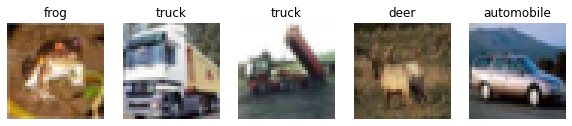

In [11]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

# Display the first few images
num_images_to_display = 5
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

plt.figure(figsize=(10, 2))
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(train_images[i])
    plt.title(class_names[train_labels[i][0]])
    plt.axis("off")

plt.show()

In [12]:
# Load CIFAR-10 dataset
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images = train_images / 255.0

# Create an instance of ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

# Create a generator from the data
train_generator = train_datagen.flow(train_images, batch_size=512, shuffle=True)

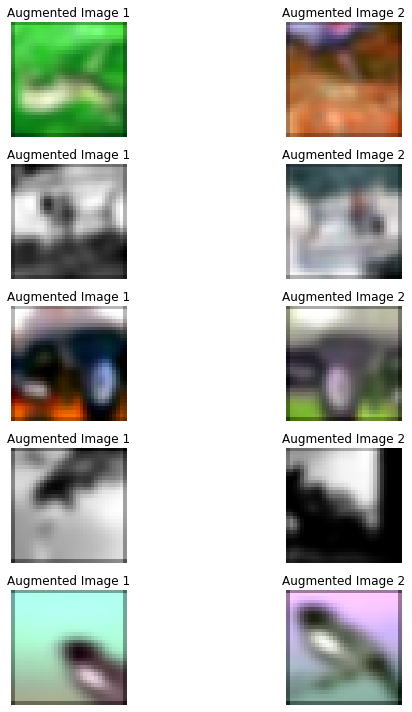

In [13]:
# Create an instance of SimCLRDataGenerator
simclr_data_gen = SimCLRDataGenerator(train_generator, batch_size=512)

# Show augmented images
simclr_data_gen.show_augmented_images(num_pairs=5)

# Create Encoder and Projection Head
see utils encoder_projection

# Loss function

see utils loss_function

# Train the Contrastive Model

In [14]:
#instantiate SimCLREncoder
simclr_encoder = SimCLREncoder()

#the paper used LARS, but we use adam
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

num_epochs = 3
temperature = 0.5  #temperature parameter for NT-Xent loss
cumulative_loss = 0.0

best_loss = float('inf')  

#training
for epoch in range(num_epochs):
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    simclr_train_generator = SimCLRDataGenerator(train_generator)

    augmented_data = simclr_train_generator.generate()

    batch_generator = simclr_encoder.process_batch(augmented_data)
    
    cumulative_loss = 0.0
    batch_index = 0

    #limit the number of batches to 100 per epoch to save time
    while batch_index < 100:
        
        #fetch the next batch of augmented images
        with tf.GradientTape() as tape:
            
            batch_index += 1
            projected_representations_1, projected_representations_2 = next(batch_generator)
            
            #concatenate the representations along the batch dimension
            concatenated_representations = tf.concat([projected_representations_1, projected_representations_2], axis=0)

            #compute the NT-Xent loss
            loss = nt_xent_loss(concatenated_representations, temperature)

            #compute gradients with respect to the trainable variables of the encoder and projection head
            gradients = tape.gradient(loss, simclr_encoder.encoder_model.trainable_variables + simclr_encoder.projection_head.trainable_variables)
            
            #apply gradients to update the encoder and projection head
            optimizer.apply_gradients(zip(gradients, simclr_encoder.encoder_model.trainable_variables + simclr_encoder.projection_head.trainable_variables))
        
            cumulative_loss += loss.numpy()
            if (batch_index % 25) == 0 and (cumulative_loss < best_loss):
                best_loss = cumulative_loss
                print(f"batch {batch_index} with improved average loss: {cumulative_loss / batch_index}")


Epoch 1/3
batch 25 with improved average loss: 4.153346548080444
Epoch 2/3
batch 25 with improved average loss: 3.126771774291992
Epoch 3/3
batch 25 with improved average loss: 3.037949504852295


# Save Model

In [15]:
simclr_encoder.save_models('resnet101model/encoder_model', 'resnet101model/projection_head_model')

2023-12-17 02:44:33.144266: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: resnet101model/encoder_model/assets
INFO:tensorflow:Assets written to: resnet101model/projection_head_model/assets
Encoder model saved to resnet101model/encoder_model
Projection head saved to resnet101model/projection_head_model


In [16]:
loaded_encoder_model, loaded_projection_head = SimCLREncoder.load_models('resnet101model/encoder_model', 'resnet101model/projection_head_model')

simclr_encoder = SimCLREncoder(trainable = False)

# Set the loaded models
simclr_encoder.set_models(loaded_encoder_model, loaded_projection_head)

# Supervised Model

In [17]:
# check size
loaded_encoder_model.input, loaded_encoder_model.output
loaded_projection_head.input, loaded_projection_head.output

(<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'dense_4_input')>,
 <KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense_5')>)

## Train the Supervised method

In [18]:
#load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

#normalize
train_images = train_images / 255.0
test_images = test_images / 255.0

#convert labels to categorical
train_labels_categorical = to_categorical(train_labels)
test_labels_categorical = to_categorical(test_labels)

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)
train_generator = train_datagen.flow(
    train_images,
    train_labels_categorical,
    batch_size=512,
    shuffle=True
)

test_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)
test_generator = test_datagen.flow(
    test_images,
    test_labels_categorical,
    batch_size=512,
    shuffle=True
)

In [19]:
# as the contrastive learning model does not associate output with label
# the following function aims to make the connection

def extract_features(encoder_model, generator):
    features = []
    labels = []
    steps_per_epoch = generator.n // generator.batch_size

    for imgs, lbls in tqdm(generator, total=steps_per_epoch):
        encoder_features = loaded_encoder_model.predict(imgs)
        batch_features = loaded_projection_head.predict(encoder_features)
        features.append(batch_features)
        labels.append(lbls)
        if len(features) * generator.batch_size >= generator.n:  
            break
    return np.vstack(features), np.vstack(labels)


In [20]:
# the above function requires this command
tf.data.experimental.enable_debug_mode()

train_features, train_labels = extract_features(simclr_encoder, train_generator)
test_features, test_labels = extract_features(simclr_encoder, test_generator)

100%|██████████| 19/19 [00:43<00:00,  2.30s/it]


In [21]:
#train a supervised model with 100% labels to check the accuracy
input_shape = train_features.shape[1:]
num_classes = 10

optimizer = Adam(learning_rate=0.001)

classifier_input = Input(shape=input_shape)

x = Dense(512, activation='relu')(classifier_input)
x = Dense(256, activation='relu')(x)

output = Dense(num_classes, activation='softmax')(x)

classifier_model = Model(inputs=classifier_input, outputs=output)

classifier_model.compile(optimizer= optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [22]:
#training
classifier_model.fit(train_features, train_labels, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 3s 1ms/step - loss: 2.6261 - accuracy: 0.2022
Epoch 2/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.3510 - accuracy: 0.2112
Epoch 3/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.2845 - accuracy: 0.2122
Epoch 4/10
1563/1563 [==============================] - 2s 2ms/step - loss: 2.1925 - accuracy: 0.2134
Epoch 5/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.2082 - accuracy: 0.2142
Epoch 6/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.2515 - accuracy: 0.2136
Epoch 7/10
1563/1563 [==============================] - 2s 2ms/step - loss: 2.2293 - accuracy: 0.2149
Epoch 8/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.1977 - accuracy: 0.2154
Epoch 9/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.1509 - accuracy: 0.2160
Epoch 10/10
1563/1563 [==============================] - 2s 1ms/step - loss: 2.133

In [23]:
#check test accuracy
loss, accuracy = classifier_model.evaluate(test_features, test_labels)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")


313/313 [==============================] - 0s 821us/step - loss: 2.1345 - accuracy: 0.2176
Test Loss: 2.134481430053711
Test Accuracy: 21.76%


In [24]:
#generate requirement txt for this specific file
!pip freeze > requirements.txt